# Example 2: mouse blood lineage networks
A pipeline providing an example of ShareNet's usage on a mouse blood lineage dataset is included in the ```~/sharenet/example2``` subdirectory. Here, we go through the different steps associated with this pipeline.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
def convert_method_name(name):
    method_dict = {'genie': 'GENIE3','pidc':'PIDC','corr': 'Pearson','gaussian': 'BVS'}
    for m in method_dict.keys():
        if m in name:
            new_name = method_dict[m]
    return new_name

def convert_dataset_name(name):
    if 'nonspecific' in name:
        return 'Non-Specific ChIP'
    elif 'specific' in name:
        return 'Specific ChIP'
    elif 'STRING' in name:
        return 'STRING'

## Running ShareNet

A Bash script, named ```run_example2.sh```, is included in ```~/sharenet/example2``` subdirectory. This script runs the below command, which fits the ShareNet model to the set of networks inferred using PIDC in the mouse blood lineage dataset. The input data required to perform this step (i.e. the initial network estimates and the network edge score standard deviation estimates) are provided in the ```~/sharenet/example2/data``` subdirectory.

```
python -u "${script_dir}/sharenet_example2.py" -d $data_dir -r $results_dir -f "pidc.edges.txt.gz" -sf "pidc.edges.txt.gz" -K 24 -nc 10 -tol 0.01
```

A description of the various flags used in this command are as follows.  
- ```-d```: data directory (path to the directory that includes the initial network estimates and standard deviation estimates)  
- ```-r```: results directory (path to the directory where the revised network edge scores and other variational parameters are to be written)
- ```-f```: file name for the initial network estimates (suffix of the file names for the initial network estimates; in this example, the file names are in the format "cluster{cluster_no}.pidc.edges.txt.gz")  
- ```-sf```: file name for the standard deviation estimates (suffix of the file names for the standard deviation estimates; in this example, the file names are in the format "V.cluster{cluster_no}.pidc.edges.txt.gz")  
- ```-K```: number of cell types to consider from the dataset (in this example, the mouse blood lineage dataset contains 24 clusters, or cell types)  
- ```-nc```: number of mixture components in the ShareNet model  
- ```-K```: number of cell types to consider from the dataset (in this example, the mouse blood lineage dataset contains 24 clusters, or cell types)  
- ```-tol```: tolerance criterion for convergence  

## Evaluating Accuracy
We also include a Bash script to calculate the accuracy of the baseline PIDC networks and the networks inferred using ShareNet applied to the initial PIDC networks. The script writes the accuracy results to a separate subdirectory ```~/sharenet/example2/accuracy``` using the set of reference networks that can be found in ```~/sharenet/example2/reference```.  

Here is an example of one command in this script.  
```python -u "${script_dir}/sharenet_accuracy.py" -d $base_dir -r $results_dir -K 24 -f $file_name -rn "STRING"```

The various flags used in this command are as follows.  
- ```-d```: base data directory (path to the base directory that includes the ```/reference/``` subdirectory and where the ```/accuracy/``` subdirectory will be written)  
- ```-r```: results directory (path to the directory where the revised network edge scores and other variational parameters are to be written)
- ```-K```: number of cell types to consider from the dataset (in this example, the mouse blood lineage dataset contains 24 clusters, or cell types)  
- ```-f```: file name for the initial network estimates (suffix of the file names for the initial network estimates; in this example, the file names are in the format "cluster{cluster_no}.pidc.edges.txt.gz")  
- ```-rn```: reference network (reference network against which the inferrred networks are to be compared)  

## Plot Results

After running the scripts for ShareNet and calculating the network accuracy results, plots used to compare the accuracy of networks inferred with and without ShareNet can be generated with the code below. 

### AUPRC Ratio: With vs. Without ShareNet

In [4]:
data_dir = '../sharenet/example2/reference'
baseline_df = pd.read_csv(os.path.join(data_dir,'baseline_auprc.csv'))
baseline_df.index = baseline_df['ref_network'].values

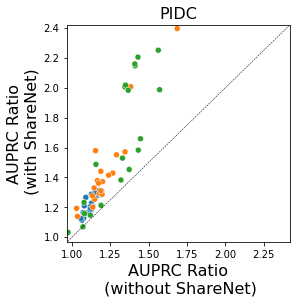

In [9]:
from scipy.stats import wilcoxon
                     
results_dir = '../sharenet/example2/accuracy'

method = 'sharenet.nc10'
measure = 'auprc'

base_method_list = ['pidc.edges']
df_list = []
for base_method in base_method_list:
    for ref_network in ['nonspecific_chip','STRING','specific_chip']:
        file_name = '{}.{}.csv'.format(ref_network,base_method)
        df = pd.read_csv(os.path.join(results_dir,file_name))
        df['method'] = base_method
        df['ref_network'] = ref_network
        df_list.append(df)
noshare_df = pd.concat(df_list)

df_list = []
for base_method in base_method_list:
    for ref_network in ['nonspecific_chip','STRING','specific_chip']:
        file_name = '{}.{}.{}.csv'.format(ref_network,method,base_method)
        df = pd.read_csv(os.path.join(results_dir,file_name))
        df['method'] = base_method
        df['ref_network'] = ref_network
        df_list.append(df)
share_df = pd.concat(df_list)

for base_method in base_method_list:
    data_dict = {'x1': [],'x2': [],'ref_network': [],'cluster_no': []}
    cluster_no_list = sorted(list(set(share_df[share_df['ref_network'] == ref_network]['cluster_no'])))
    for ref_network in ['nonspecific_chip','STRING','specific_chip']:
        for cluster_no in cluster_no_list:
            noshare_cond = (noshare_df['cluster_no'] == cluster_no) & \
                (noshare_df['ref_network'] == ref_network) & \
                (noshare_df['method'] == base_method)
            share_cond = (share_df['cluster_no'] == cluster_no) & \
                (share_df['ref_network'] == ref_network) & \
                (share_df['method'] == base_method)
            
            noshare_val = noshare_df[noshare_cond][measure].values[0]
            share_val = share_df[share_cond][measure].values[0]

            if ref_network in ['nonspecific_chip','STRING']:
                baseline_auprc = baseline_df.loc[ref_network]['auprc']
            else:
                baseline_auprc = baseline_df.loc['{}_specific_chip'.format(cluster_no)]['auprc']
                
            data_dict['x1'].append(noshare_val/baseline_auprc)
            data_dict['x2'].append(share_val/baseline_auprc)
            data_dict['cluster_no'].append(cluster_no)
            data_dict['ref_network'].append(ref_network)
    df = pd.DataFrame(data_dict)
    df['ref_network'] = [convert_dataset_name(m) for m in df['ref_network']]
    
    plt.figure(figsize=(4,4))
    plt.plot(np.linspace(0,50),np.linspace(0,50),c='black',linestyle='--',lw=0.5)
    
    sns.scatterplot(x='x1',y='x2',data=df,hue='ref_network')
    
    min_x = min(df['x1'].min(),df['x2'].min())
    max_x = max(df['x1'].max(),df['x2'].max())

    plt.xlim(min_x*0.99,max_x*1.01)
    plt.ylim(min_x*0.99,max_x*1.01)
    plt.xlabel(measure.upper() + ' Ratio\n (without ShareNet)',fontsize=16)
    plt.ylabel(measure.upper() + ' Ratio\n (with ShareNet)',fontsize=16)
    plt.title(convert_method_name(base_method.split('.')[0]),fontsize=16)
    
    lg = plt.legend(fontsize=16,bbox_to_anchor=(1,1),markerscale=2)
    lg.remove()
    plt.show()

### Wilcoxon Rank-Sum Test 

In [5]:
print(wilcoxon(df['x2'],y=df['x1'],alternative='greater'))

WilcoxonResult(statistic=1829.0, pvalue=8.570746990858083e-12)
